## Dataset Creation 

In [1]:
import numpy as np
import torch 
from uqregressors.utils.validate_dataset import clean_dataset, validate_dataset

seed = 42 

np.random.seed(seed)
torch.manual_seed(seed)

rng = np.random.RandomState(seed)
def true_function(x):
    return np.sin(3 * np.pi * x)

X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_true = true_function(X_test)

X_train = np.sort(rng.rand(100, 1))
y_train = true_function(X_train).ravel() 

X_train, y_train = clean_dataset(X_train, y_train)
validate_dataset(X_train, y_train, name="Synthetic Sine")

Summary for: Synthetic Sine dataset
Number of samples: 100
Number of features: 1
Output shape: (100, 1)
Dataset validation passed.



## Plotting

In [2]:
import matplotlib.pyplot as plt

def plot_uncertainty_results(mean, lower, upper, model_name): 
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, y_true, 'g--', label="True Function")
    plt.scatter(X_train, y_train, color='black', label="Training data", alpha=0.6)
    plt.plot(X_test, mean, label="Predicted Mean", color="blue")
    plt.fill_between(X_test.ravel(), lower, upper, alpha=0.3, color="blue", label = "Uncertainty Interval")
    plt.legend()
    plt.title(f"{model_name} Uncertainty Test")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

## MC Dropout

[Logger-25132] epoch=0, train_loss=1.9978777170181274
[Logger-25132] epoch=50, train_loss=0.5394803881645203
[Logger-25132] epoch=100, train_loss=0.5821924805641174
[Logger-25132] epoch=150, train_loss=0.3230440616607666
[Logger-25132] epoch=200, train_loss=0.1804857701063156
[Logger-25132] epoch=250, train_loss=0.11403848230838776
[Logger-25132] epoch=300, train_loss=0.11075268685817719
[Logger-25132] epoch=350, train_loss=0.11259673535823822
[Logger-25132] epoch=400, train_loss=0.0984770655632019
[Logger-25132] epoch=450, train_loss=0.10576505959033966
[Logger-25132] epoch=500, train_loss=0.09776131063699722
[Logger-25132] epoch=550, train_loss=0.11294320970773697
[Logger-25132] epoch=600, train_loss=0.11644622683525085
[Logger-25132] epoch=650, train_loss=0.075726717710495
[Logger-25132] epoch=700, train_loss=0.1085755005478859
[Logger-25132] epoch=750, train_loss=0.06280882656574249
[Logger-25132] epoch=800, train_loss=0.06288458406925201
[Logger-25132] epoch=850, train_loss=0.1139

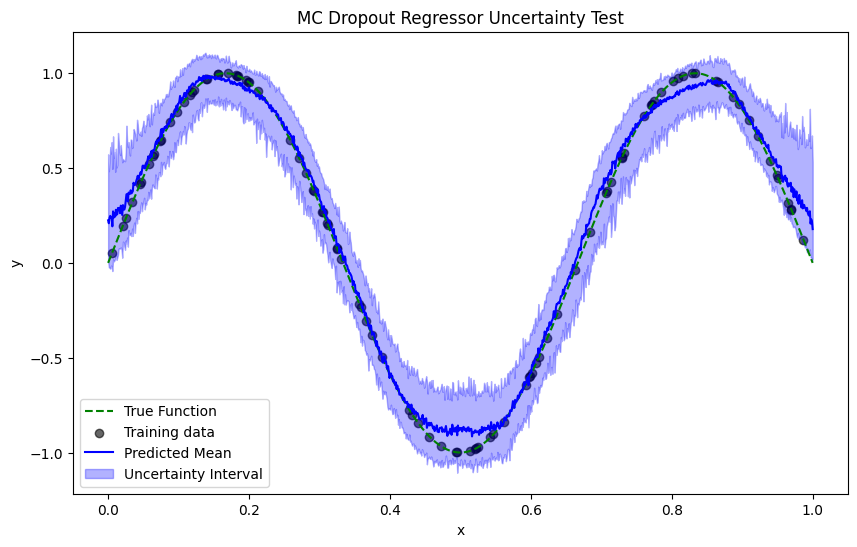

In [4]:
from uqregressors.bayesian.dropout import MCDropoutRegressor

dropout = MCDropoutRegressor(
    hidden_sizes=[100, 100],
    dropout=0.1,
    alpha=0.1,  # 90% confidence
    n_samples=100,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    use_wandb=False
)

dropout.fit(X_train, y_train)
dropout_sol = dropout.predict(X_test)

plot_uncertainty_results(*dropout_sol, "MC Dropout Regressor")

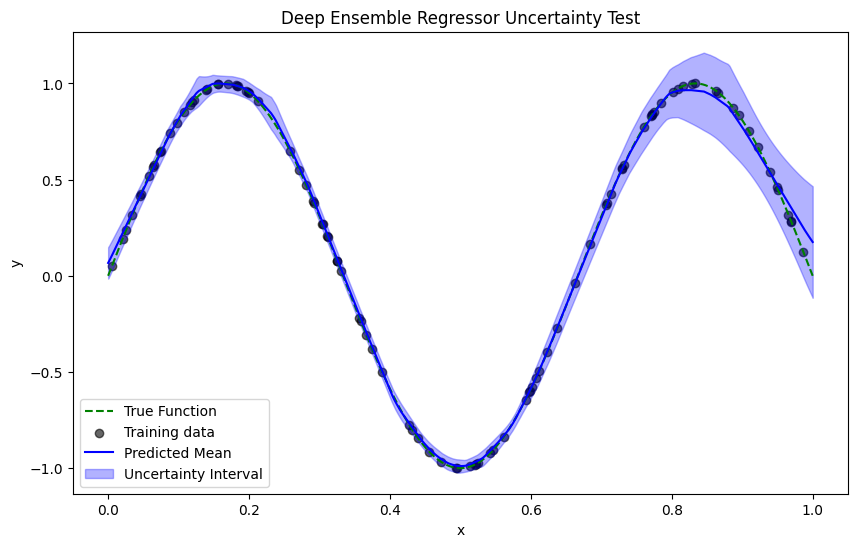

In [3]:
from uqregressors.bayesian.deep_ens import DeepEnsembleRegressor

deep_ens = DeepEnsembleRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

deep_ens.fit(X_train, y_train)
deep_ens_sol = deep_ens.predict(X_test)

plot_uncertainty_results(*deep_ens_sol, "Deep Ensemble Regressor")

## Standard Gaussian Process Regression (GPR)

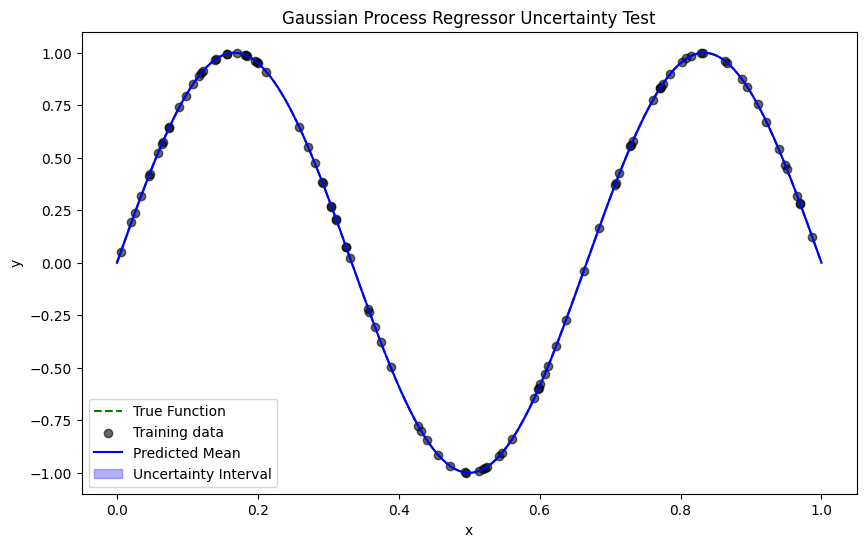

In [6]:
from uqregressors.bayesian.gaussian_process import GPRegressor
from sklearn.gaussian_process.kernels import RBF

gp_kwargs = {"normalize_y": True}
gpr = GPRegressor(kernel= RBF(length_scale=0.2, length_scale_bounds=(0.05, 1)), alpha=0.1, gp_kwargs=gp_kwargs)
gpr.fit(X_train, y_train)
gp_sol = gpr.predict(X_test)
plot_uncertainty_results(*gp_sol, "Gaussian Process Regressor")

## BBMM Gaussian Process

[Logger-25132] epoch=0, train_loss=1.0277092456817627
[Logger-25132] epoch=50, train_loss=-1.492130994796753
[Logger-25132] epoch=100, train_loss=-3.05782413482666
[Logger-25132] epoch=150, train_loss=-3.1835126876831055
[Logger-25132] epoch=200, train_loss=-3.202526807785034
[Logger-25132] epoch=250, train_loss=-3.21077299118042
[Logger-25132] epoch=300, train_loss=-3.215054512023926
[Logger-25132] epoch=350, train_loss=-3.217118740081787
[Logger-25132] epoch=400, train_loss=-3.2191617488861084
[Logger-25132] epoch=450, train_loss=-3.220369815826416
[Logger-25132] epoch=500, train_loss=-3.22139310836792
[Logger-25132] epoch=550, train_loss=-3.2223870754241943
[Logger-25132] epoch=600, train_loss=-3.222482204437256
[Logger-25132] epoch=650, train_loss=-3.2234184741973877
[Logger-25132] epoch=700, train_loss=-3.2234749794006348
[Logger-25132] epoch=750, train_loss=-3.223423719406128
[Logger-25132] epoch=800, train_loss=-3.223464012145996
[Logger-25132] epoch=850, train_loss=-3.224402666

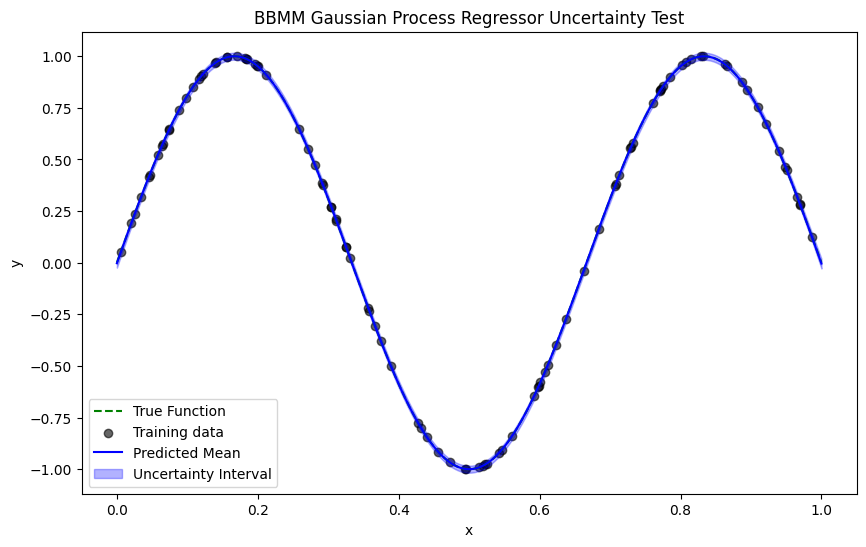

In [7]:
from uqregressors.bayesian.gaussian_process_torch import GPRegressorTorch
import gpytorch

bbmm_gp = GPRegressorTorch(kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), 
                           likelihood=gpytorch.likelihoods.GaussianLikelihood(), 
                           alpha = 0.1,
                           epochs=1000,
                           learning_rate=1e-1,
                           device="cpu",
                           use_wandb=False)

bbmm_gp.fit(X_train, y_train)
bbmm_gp_sol = bbmm_gp.predict(X_test)
plot_uncertainty_results(*bbmm_gp_sol, "BBMM Gaussian Process Regressor")

## K-fold Conformal Quantile Regression 

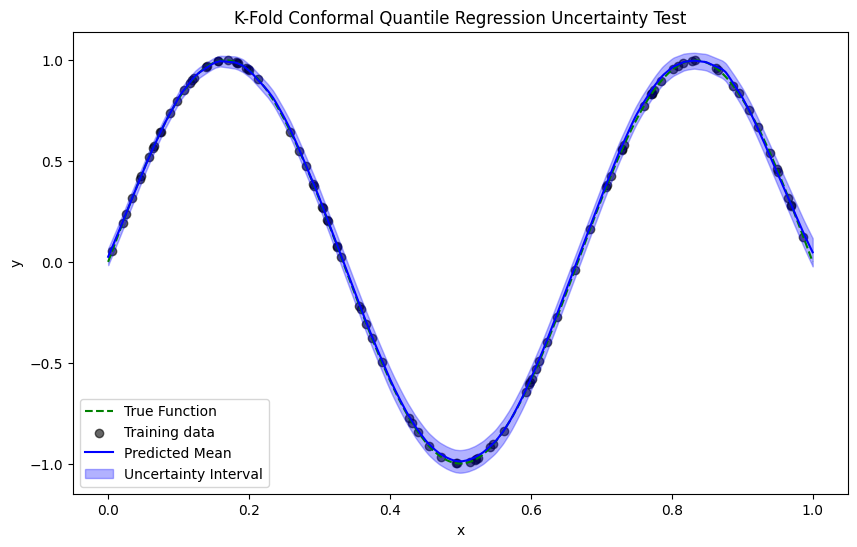

In [8]:
from uqregressors.conformal.k_fold_cqr import KFoldCQR
    
k_fold_cqr = KFoldCQR(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=2500,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

k_fold_cqr.fit(X_train, y_train)
k_fold_cqr_sol = k_fold_cqr.predict(X_test)

plot_uncertainty_results(*k_fold_cqr_sol, "K-Fold Conformal Quantile Regression")

## Normalized ConformalEns

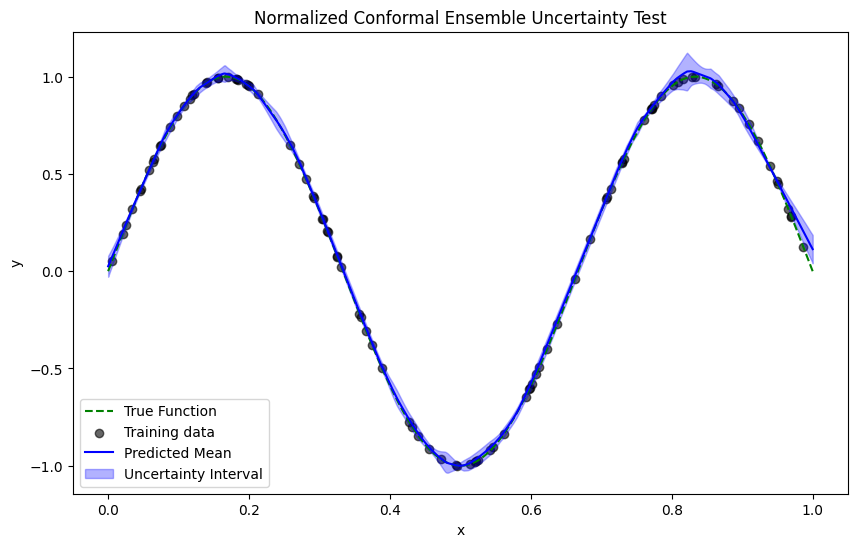

In [9]:
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor

conformal_ens = ConformalEnsRegressor(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    cal_size=0.2,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

conformal_ens.fit(X_train, y_train)
conformal_ens_sol = conformal_ens.predict(X_test)

plot_uncertainty_results(*conformal_ens_sol, "Normalized Conformal Ensemble")

## Normalized ConformalGauss

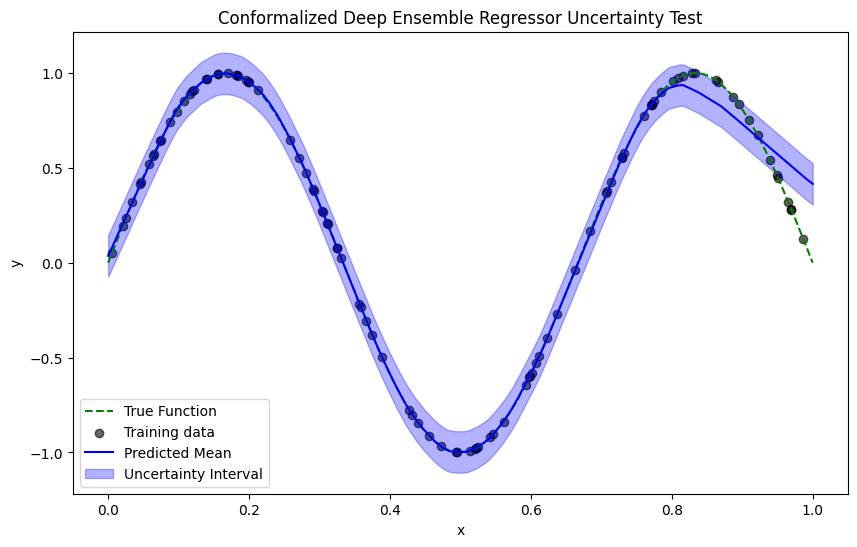

In [10]:
from uqregressors.conformal.conformal_deep_ens import ConformalizedDeepEns

conf_deep_ens = ConformalizedDeepEns(n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,  # 90% confidence
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    n_jobs=5,
    use_wandb=False)

conf_deep_ens.fit(X_train, y_train)
conf_deep_ens_sol = conf_deep_ens.predict(X_test)

plot_uncertainty_results(*conf_deep_ens_sol, "Conformalized Deep Ensemble Regressor")

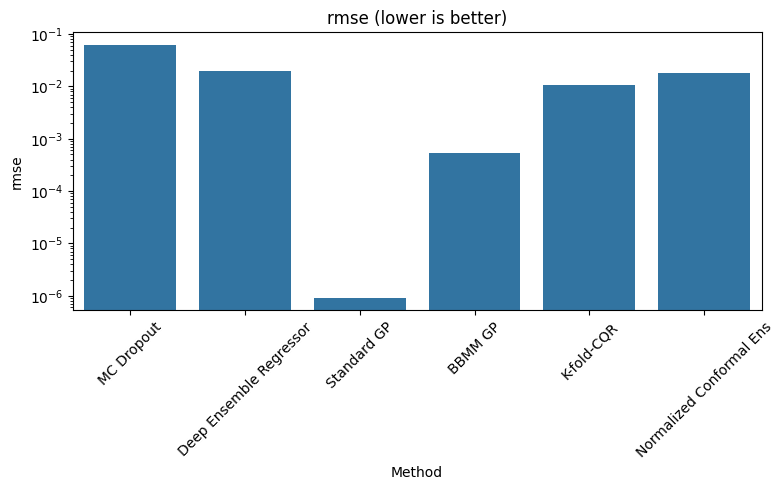

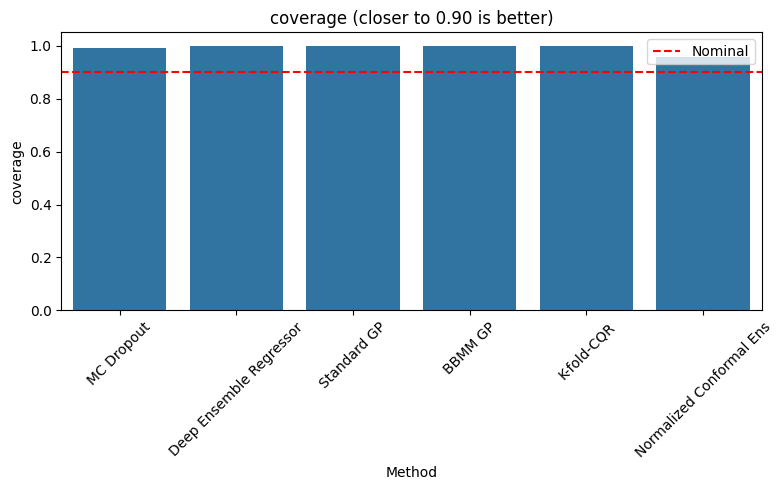

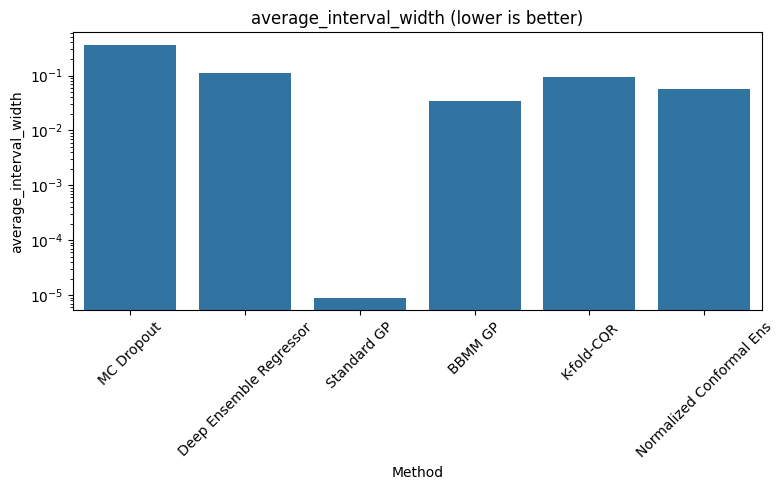

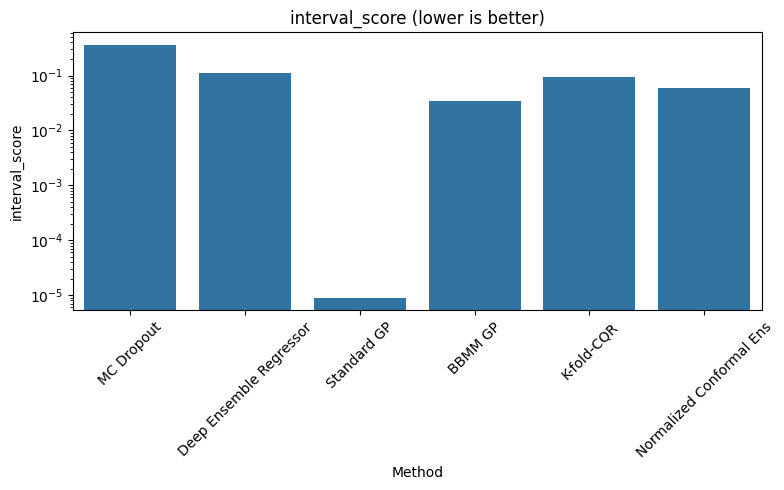

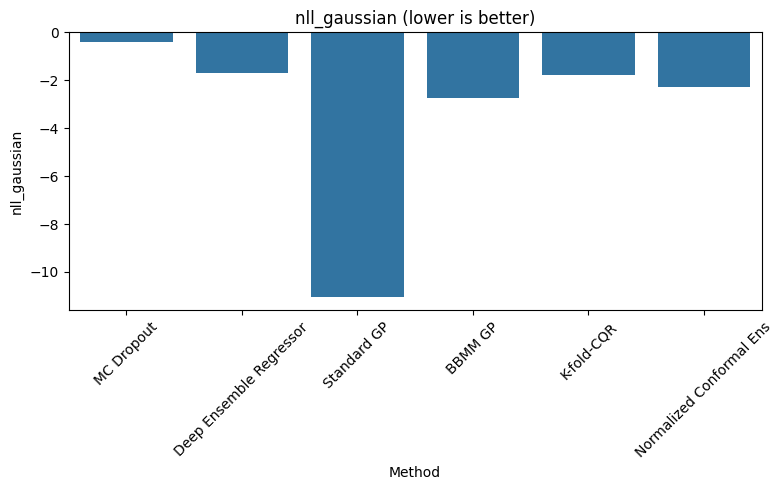

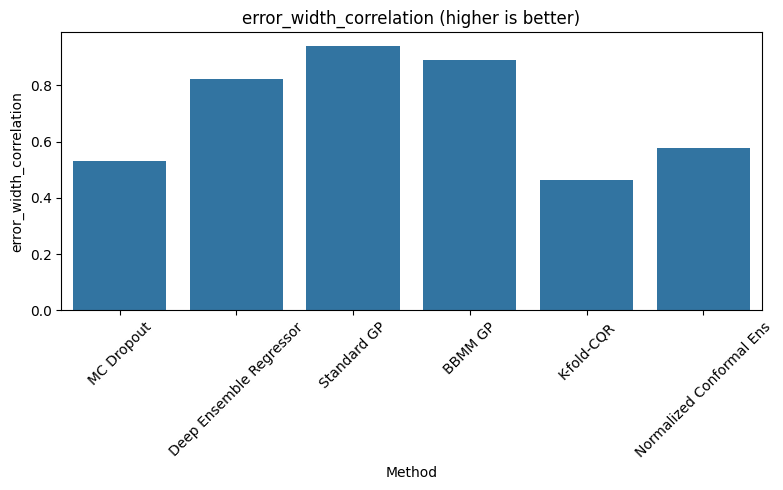

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from uqregressors.metrics.metrics import compute_all_metrics

alpha=0.1

sol_dict = {"MC Dropout": dropout_sol, 
            "Deep Ensemble Regressor": deep_ens_sol, 
            "Standard GP": gp_sol, 
            "BBMM GP": bbmm_gp_sol, 
            "K-fold-CQR": k_fold_cqr_sol, 
            "Normalized Conformal Ens": conformal_ens_sol}

def evaluate_all_methods(sol_dict, y_true, alpha=0.1):
    rows = []
    for method, (mean, lower, upper) in sol_dict.items():
        metrics = compute_all_metrics(mean, lower, upper, y_true, alpha)
        metrics["method"] = method
        rows.append(metrics)
    return pd.DataFrame(rows)

def plot_metrics(df, alpha=0.1, log_metrics=None, figsize=(8, 5)):
    """
    Plots each metric in a separate subplot with appropriate annotations and log scales.

    Args:
        df: DataFrame with columns ["method", metric1, metric2, ...]
        alpha: Confidence level used for calculating coverage.
        log_metrics: List of metrics to plot on log scale.
        figsize: Base figure size for each subplot.
    """
    log_metrics = log_metrics or ["rmse", "interval_score", "average_interval_width"]
    metrics = [col for col in df.columns if col != "method"]
    
    # Helpful title annotations
    better_direction = {
        "rmse": "lower is better",
        "nll_gaussian": "lower is better",
        "interval_score": "lower is better",
        "coverage": "closer to {:.2f} is better".format(1 - alpha),
        "average_interval_width": "lower is better",
        "error_width_correlation":"higher is better"
    }

    for metric in metrics:
        plt.figure(figsize=figsize)
        sns.barplot(data=df, x="method", y=metric)
        plt.xticks(rotation=45)
        
        # Set log scale if appropriate
        if metric in log_metrics:
            plt.yscale("log")

        # Add coverage reference line
        if metric == "coverage":
            plt.axhline(1 - alpha, color="red", linestyle="--", label="Nominal")
            plt.legend()

        title = f"{metric} ({better_direction.get(metric, '')})"
        plt.title(title)
        plt.ylabel(metric)
        plt.xlabel("Method")
        plt.tight_layout()
        plt.show()

metrics_df = evaluate_all_methods(sol_dict, y_true, alpha=0.1)
plot_metrics(metrics_df)